# TopoStats - 457 Investigations

Looks to investigate the issues reported in [#457](https://github.com/AFM-SPM/TopoStats/issues/457).

In [1]:
import json
from pathlib import Path

from ipywidgets import FileUpload
import matplotlib.pyplot as plt
import numpy as np

from topostats.filters import Filters
from topostats.grains import Grains
from topostats.grainstats import GrainStats
from topostats.io import find_files, read_yaml, write_yaml, LoadScans
from topostats.logs.logs import setup_logger, LOGGER_NAME
from topostats.plottingfuncs import Images
from topostats.tracing.dnatracing import dnaTrace, traceStats
from topostats.utils import update_config

In [2]:
# Set the base directory to be current working directory of the Notebook
BASE_DIR = Path().cwd()
# Alternatively if you know where your files area comment the above line and uncomment the below adjust it for your use.
# BASE_DIR = Path("/path/to/where/my/files/are")
# Adjust the file extension approriately.
FILE_EXT = ".spm"
# Search for *.spm files one directory level up from the current notebooks
image_files = find_files(base_dir=BASE_DIR.parent / "tests", file_ext=FILE_EXT)

## Loading a Configuration

In [37]:
config = read_yaml(BASE_DIR.parent / "topostats" / "default_config.yaml")


In [6]:
loading_config = config["loading"]
filter_config = config["filter"]
filter_config.pop("run")
grain_config = config["grains"]
grain_config.pop("run")
grainstats_config = config["grainstats"]
grainstats_config.pop("run")
dnatracing_config = config["dnatracing"]
dnatracing_config.pop("run")
plotting_config = config["plotting"]
plotting_config.pop("run")
plotting_config["image_set"] = "all"

## Load Scans


[Mon, 06 Mar 2023 07:35:57] [INFO    ] [topostats] Extracting image from /home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle.spm


[Mon, 06 Mar 2023 07:35:57] [INFO    ] [topostats] Loading image from : /home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle.spm


[Mon, 06 Mar 2023 07:35:57] [INFO    ] [topostats] [minicircle] : Loaded image from : /home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle.spm


[Mon, 06 Mar 2023 07:35:57] [INFO    ] [topostats] [minicircle] : Extracted channel Height


[Mon, 06 Mar 2023 07:35:57] [INFO    ] [topostats] [minicircle] : Pixel to nm scaling : 0.4940029296875


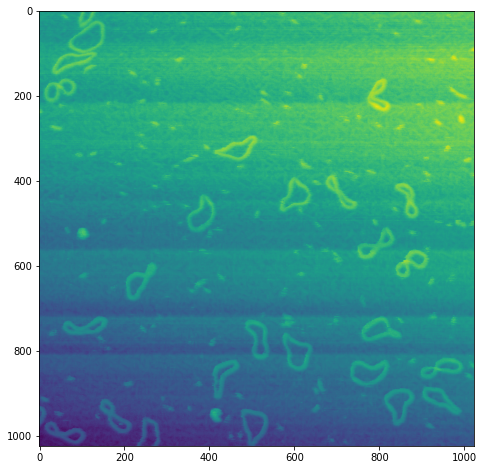

In [7]:
all_scan_data = LoadScans(image_files, **config["loading"])
all_scan_data.get_data()


# Plot the loaded scan in its raw format
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(all_scan_data.image)
plt.show()

Now that we have loaded the data we can start to process it. The first step is filtering the image.

## Filter Image

Now that we have found some images the first step in processing is to filter them to remove some of the noise. This is
achieved using the `Filters()` class.  There are number of options that we need to specify which are described in the
table below and also in the [documentation](https://topostats.readthedocs.io/en/dev/topostats.filters.html). 


One of the key fields you may wish to change is the `channel`.

Once we setup a `Filters` object we can call the different methods that are available for it. There are lots of
different methods that carry out the different steps but for convenience the `filter_image()` method runs all these.

The following section instantiates ("sets up") an object called `filtered_image` of type `Filters` using the first file
found (`image_files[0]`) and the various options from the dictionary `filter_config` dictionary.


In [8]:
from topostats.filters import Filters

filtered_image = Filters(
    image=all_scan_data.img_dict["minicircle"]["image"],
    filename=all_scan_data.img_dict["minicircle"]["img_path"],
    pixel_to_nm_scaling=all_scan_data.img_dict["minicircle"]["px_2_nm"],
    row_alignment_quantile=filter_config["row_alignment_quantile"],
    threshold_method=filter_config["threshold_method"],
    otsu_threshold_multiplier=filter_config["otsu_threshold_multiplier"],
    threshold_std_dev=filter_config["threshold_std_dev"],
    threshold_absolute=filter_config["threshold_absolute"],
    gaussian_size=filter_config["gaussian_size"],
    gaussian_mode=filter_config["gaussian_mode"],
    remove_scars=filter_config["remove_scars"],
)


# NB - Because of the one-to-one mapping of configuration options to Filters() options we can use keyword arguments to
#      unpack the options, the below is the same as explicitly stating the values you want to map.
filtered_image = Filters(
    image=all_scan_data.img_dict["minicircle"]["image"],
    filename=all_scan_data.img_dict["minicircle"]["img_path"],
    pixel_to_nm_scaling=all_scan_data.img_dict["minicircle"]["px_2_nm"],
    **filter_config,
)
filtered_image.filter_image()

[Mon, 06 Mar 2023 07:36:04] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Median flattening without mask


[Mon, 06 Mar 2023 07:36:04] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Plane tilt removal without mask


[Mon, 06 Mar 2023 07:36:04] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : x-polyfit 1st order: [ 0.00319595 -1.71575752]


[Mon, 06 Mar 2023 07:36:04] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : y-polyfit 1st order: [ 3.50284854e-19 -1.67027638e-16]


[Mon, 06 Mar 2023 07:36:04] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Removing x plane tilt


[Mon, 06 Mar 2023 07:36:04] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : removing y plane tilt


[Mon, 06 Mar 2023 07:36:05] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Remove quadratic bow without mask


[Mon, 06 Mar 2023 07:36:05] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : x polyfit 2nd order: [-7.84571521e-09  8.02616666e-06 -1.71712464e+00]


[Mon, 06 Mar 2023 07:36:05] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Initial scar removal


[Mon, 06 Mar 2023 07:36:05] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Removing scars


[Mon, 06 Mar 2023 07:36:16] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Masking (upper) Threshold: -0.9318618283274199


[Mon, 06 Mar 2023 07:36:16] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Masking (lower) Threshold: -8.236200486765377


[Mon, 06 Mar 2023 07:36:16] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Median flattening with mask


[Mon, 06 Mar 2023 07:36:16] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Plane tilt removal with mask


[Mon, 06 Mar 2023 07:36:16] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : x-polyfit 1st order: [ 1.11114762e-05 -5.76417551e-03]


[Mon, 06 Mar 2023 07:36:16] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : y-polyfit 1st order: [-3.81909653e-21  2.17030831e-18]


[Mon, 06 Mar 2023 07:36:16] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Removing x plane tilt


[Mon, 06 Mar 2023 07:36:17] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : removing y plane tilt


[Mon, 06 Mar 2023 07:36:17] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Remove quadratic bow with mask


[Mon, 06 Mar 2023 07:36:17] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : x polyfit 2nd order: [-6.32624539e-08  6.47174903e-05 -1.67877214e-02]


[Mon, 06 Mar 2023 07:36:17] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Secondary scar removal


[Mon, 06 Mar 2023 07:36:17] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Removing scars


[Mon, 06 Mar 2023 07:36:28] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Zero averaging background : -0.009763323144947215 nm


[Mon, 06 Mar 2023 07:36:28] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Applying Gaussian filter (mode : nearest; Gaussian blur (px) : 1.0121397464510862).


The `filtered_image` now has a a number of NumPy arrays saved in the `.images` dictionary that can be accessed and plotted. To view
the names of the images (technically the dictionary keys) you can print them with `filter_image.images.keys()`...

In [9]:
print(f"Available NumPy arrays to plot in filter_image.images dictionary :\n\n{filtered_image.images.keys()}")

Available NumPy arrays to plot in filter_image.images dictionary :

dict_keys(['pixels', 'initial_median_flatten', 'initial_tilt_removal', 'initial_quadratic_removal', 'initial_scar_removal', 'masked_median_flatten', 'masked_tilt_removal', 'masked_quadratic_removal', 'secondary_scar_removal', 'scar_mask', 'mask', 'zero_average_background', 'gaussian_filtered'])


To plot the raw extracted pixels you can use the built-in NumPy method `imshow()`.


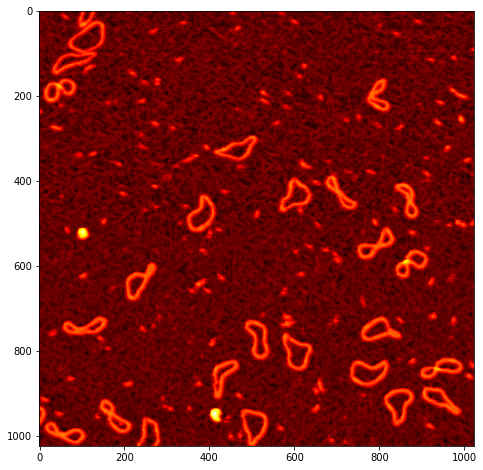

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(filtered_image.images["gaussian_filtered"], cmap="hot")
plt.show()

TopoStats includes a custom plotting class `Images`  which formats plots in a more familiar manner.

It has a number of options, please refer to the official documentation on
[configuration](https://afm-spm.github.io/TopoStats/configuration.html) under the `plotting` entry for what these values
are or the [API
reference](https://afm-spm.github.io/TopoStats/topostats.plottingfuncs.html#module-topostats.plottingfuncs).

The class requires a Numpy array, which we have just generated many of during the various filtering stages, and a number
of options. Again for convenience we use the `**plotting_config` notation to unpack the key/value pairs stored in the
`plotting_config` dictionary.




[Mon, 06 Mar 2023 07:36:32] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Image saved to : /home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle


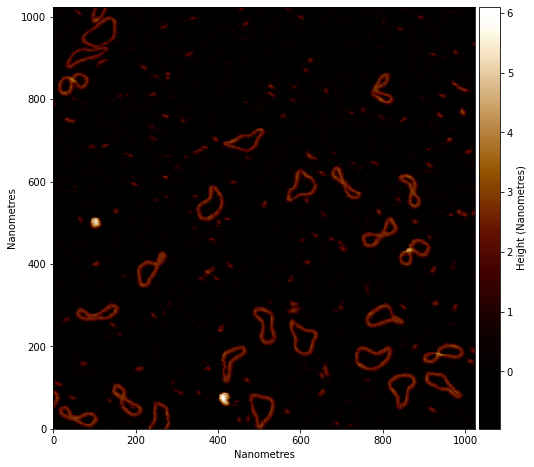

In [11]:
fig, ax = Images(
    data=filtered_image.images["gaussian_filtered"],
    filename=filtered_image.filename,
    output_dir="img/",
    save=True,
    **plotting_config,
).plot_and_save()
fig

Here we plot the image after processing and zero-averaging the background but with the `viridis` palette and
constraining the `zrange` to be between 0 and 3

[Mon, 06 Mar 2023 07:36:38] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Image saved to : /home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle


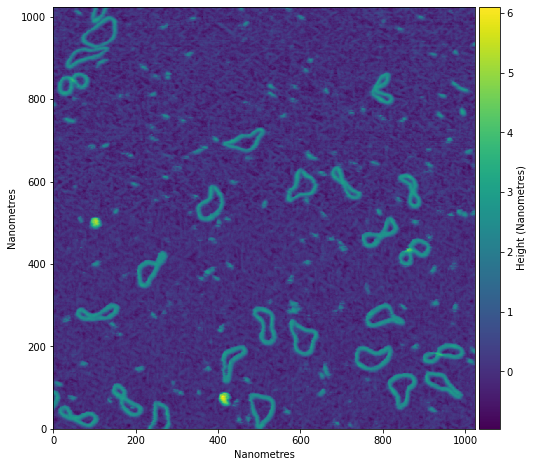

In [12]:
## TODO - Not getting fig, ax returned by plot_and_save()?
# First remove the current value for cmap in the plotting_config dictionary, otherwise an error occurs because the same
# argument will have been specified twice.
current_cmap = plotting_config.pop("cmap")
fig, ax = Images(
    data=filtered_image.images["gaussian_filtered"],
    filename=filtered_image.filename,
    output_dir="img/",
    cmap="viridis",
    save=True,
    **plotting_config,
).plot_and_save()
# Restore the value for cmap to the dictionary.
plotting_config["cmap"] = current_cmap
fig

## Finding Grains

The next step in processing the image is to find grains. This is done using the `Grains` class and we have saved the
configuration to the `grains_config` dictionary. For details of the arguments and their values please refer to the
[configuration](https://afm-spm.github.io/TopoStats/configuration.html) and the [API
reference](https://afm-spm.github.io/TopoStats/topostats.grains.html).

The most important thing required for grain finding is the resulting image from the Filtering stage, however several
other key variables are required. Again there is a one-to-one mapping between the options to the `Grains()` class and
their values in the configuration file.

The `pixel_to_nm_scaling` is one of several key variables, as is the `filename` and whilst you can specify these
yourself explicitly they are available as properties of the `filtered_image` that we have processed. As with `Filters`
the `Grains` class has a number of methods that carry out the grain finding, but there is a convenience method
`find_grains()` which calls all these in the correct order.

In [13]:
grains = Grains(
    image=filtered_image.images["zero_average_background"],
    filename=filtered_image.filename,
    pixel_to_nm_scaling=filtered_image.pixel_to_nm_scaling,
    threshold_method=grain_config["threshold_method"],
    otsu_threshold_multiplier=grain_config["otsu_threshold_multiplier"],
    threshold_std_dev=grain_config["threshold_std_dev"],
    threshold_absolute=grain_config["threshold_absolute"],
    direction=grain_config["direction"],
    smallest_grain_size_nm2=grain_config["smallest_grain_size_nm2"],
)
# NB - Again we can use the one-to-one mapping of configuration options in the grain_config we extracted.
grains = Grains(
    image=filtered_image.images["zero_average_background"],
    filename=filtered_image.filename,
    pixel_to_nm_scaling=filtered_image.pixel_to_nm_scaling,
    **grain_config,
)
grains.find_grains()

[Mon, 06 Mar 2023 07:36:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Thresholding method (grains) : std_dev


[Mon, 06 Mar 2023 07:36:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Processing upper threshold (0.8404126198725879)


[Mon, 06 Mar 2023 07:36:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Masking (upper) Threshold: 0.8404126198725879


[Mon, 06 Mar 2023 07:36:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Labelling Regions


[Mon, 06 Mar 2023 07:36:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Tidying borders


[Mon, 06 Mar 2023 07:36:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Removing noise (upper)


[Mon, 06 Mar 2023 07:36:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Area thresholding grains | Thresholds: L:204.89,U:{upper / self.pixel_to_nm_scaling**2:.2f} px^2, L:{lower:.2f}, U:{upper:.2f} nm^2.


[Mon, 06 Mar 2023 07:36:44] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Removing small / large grains (upper)


[Mon, 06 Mar 2023 07:36:44] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Area thresholding grains | Thresholds: L:1229.31,U:{upper / self.pixel_to_nm_scaling**2:.2f} px^2, L:{lower:.2f}, U:{upper:.2f} nm^2.


[Mon, 06 Mar 2023 07:36:44] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Labelling Regions


[Mon, 06 Mar 2023 07:36:44] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Region properties calculated (upper)


[Mon, 06 Mar 2023 07:36:44] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Coloured regions


[Mon, 06 Mar 2023 07:36:44] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Extracted bounding boxes (upper)


The `grains` object now also contains a series of images in the that we can plot, however, because both `lower` and
`upper` layers can be processed for grains these reside under the `grains.directions["upper"]` and `grains.directions["lower"]` dictionaries.

In [14]:
print(
    f"Available NumPy arrays to plot in grains.directions['upper'] dictionary :\n\n{grains.directions['upper'].keys()}"
)

Available NumPy arrays to plot in grains.directions['upper'] dictionary :

dict_keys(['mask_grains', 'labelled_regions_01', 'tidied_border', 'removed_noise', 'removed_small_objects', 'labelled_regions_02', 'coloured_regions'])


And we can again use the `plot_and_save()` function to plot these.

[Mon, 06 Mar 2023 07:37:54] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Image saved to : /home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle


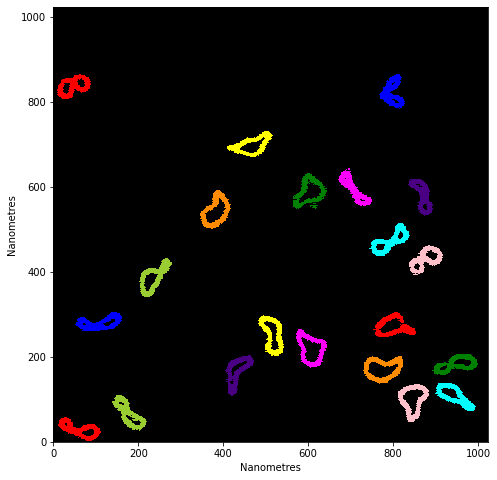

In [15]:
## TODO - Not getting fig, ax returned by plot_and_save()?
plotting_config["colorbar"] = False
fig, ax = Images(
    data=grains.directions["upper"]["coloured_regions"],
    filename=filtered_image.filename,
    output_dir="img/",
    save=True,
    **plotting_config,
).plot_and_save()
fig

### Thresholds

The thresholds can be used in different ways based on the `direction` you want to detect grains. Typically for molecular
imaging where the DNA or protein is raised above the background you will want to look for items above the `upper`
threshold. When imaging silicon though you may be interested in items below a `lower` threshold. For convenience it is
possible to look for grains that are `both` above the `upper` threshold and `lower` than the lower threshold.

This is controlled using the `config["grains"]["direction"]` configuration option which maps to the `Grains(direction=)`
option and can take three values `lower`, `upper` or `both`.

If you want to change the option you can update the `config["grains"]` dictionary as we do below. You will see that now
we are using `both` there is twice as much output as grains are detected above the reported upper Threshold (0.8064)
_and_ below the reported lower Threshold (-0.5333).

So far the thresholding method used has been `threshold_method="std_dev"` defined in the configuration file we
loaded. This calculates the mean and standard deviation of height across the whole image and then determines the
threshold by scaling the standard deviation by a given factor (defined by `threshold_std_dev`) and adding it to the mean
to give the `upper` threshold and/or subtracting if from the mean to give the `lower` threshold.

An alternative method is to use the `threshold_method="absolute"`, set the `direction=upper` and explicitly state the
`lower` and `upper` thresholds (although since we are only looking for objects above a given threshold only the `upper`
value will be used). If you wish to specify values for both they are shown below.

In [16]:
## ToDO - What are sensible values for minicircle here?
grain_config["threshold_method"] = "absolute"
grain_config["direction"] = "upper"
grain_config["threshold_absolute"]["upper"] = 0.01  # Change just the upper threshold
grain_config["threshold_absolute"]["lower"] = -2.0  # Change just the lower threshold
grain_config["threshold_absolute"] = {"lower": -2.0, "upper": 1.2}  # Change both the lower and upper threshold
grains_absolute = Grains(
    image=filtered_image.images["zero_average_background"],
    filename=filtered_image.filename,
    pixel_to_nm_scaling=filtered_image.pixel_to_nm_scaling,
    **grain_config,
)
grains_absolute.find_grains()

[Mon, 06 Mar 2023 07:39:41] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Thresholding method (grains) : absolute


[Mon, 06 Mar 2023 07:39:41] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Processing upper threshold (1.2)


[Mon, 06 Mar 2023 07:39:41] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Masking (upper) Threshold: 1.2


[Mon, 06 Mar 2023 07:39:41] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Labelling Regions


[Mon, 06 Mar 2023 07:39:41] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Tidying borders


[Mon, 06 Mar 2023 07:39:41] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Removing noise (upper)


[Mon, 06 Mar 2023 07:39:41] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Area thresholding grains | Thresholds: L:204.89,U:{upper / self.pixel_to_nm_scaling**2:.2f} px^2, L:{lower:.2f}, U:{upper:.2f} nm^2.


[Mon, 06 Mar 2023 07:39:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Removing small / large grains (upper)


[Mon, 06 Mar 2023 07:39:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Area thresholding grains | Thresholds: L:1229.31,U:{upper / self.pixel_to_nm_scaling**2:.2f} px^2, L:{lower:.2f}, U:{upper:.2f} nm^2.


[Mon, 06 Mar 2023 07:39:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Labelling Regions


[Mon, 06 Mar 2023 07:39:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Region properties calculated (upper)


[Mon, 06 Mar 2023 07:39:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Coloured regions


[Mon, 06 Mar 2023 07:39:42] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle] : Extracted bounding boxes (upper)


This is important to know because you need to know where the resulting images are stored within the `Grains.direction`
dictionary. This will have entries corresponding to the `direction` that grains have been searched for.

In [17]:
print(f"Grains available in original 'grains' (std_dev, upper) : {list(grains.directions.keys())}")
print(f"Grains available in absolute (absolute, upper)         : {list(grains_absolute.directions.keys())}")

Grains available in original 'grains' (std_dev, upper) : ['upper']
Grains available in absolute (absolute, upper)         : ['upper']


Each `direction` dictionary is a series of NumPy arrays representing the cleaned images and these can be plotted.

## Grain Statistics

Now that grains have been found we can calculate statistics on each of the grains. This is done using the `GrainStats()`
class. Again the configuration options from the YAML file map to those of the class and there is a convenience method
`calculate_stats()` which will run all steps of grain finding. However, because the class is processing results that we
have generated we have to explicitly pass in more values.

For details of what the arguments are please refer to the [API
reference](https://afm-spm.github.io/TopoStats/topostats.grainstats.html).

The `GrainStats` class returns two objects, a Pandas `pd.DataFrame` of calculated statistics and a `list` of
dictionaries containing the grain data to be plotted. We therefore instantiate ("set-up") the `grain_stats` dictionary
to hold these results and unpack each to the keys `statistics` and `plots` respectively.



In [18]:
grainstats = GrainStats(
    data=filtered_image.images["gaussian_filtered"],
    labelled_data=grains.directions["upper"]["labelled_regions_02"],
    pixel_to_nanometre_scaling=filtered_image.pixel_to_nm_scaling,
    direction="upper",
    base_output_dir="grains",
    image_name=filtered_image.filename.stem,
    **grainstats_config,
)
_temp = grainstats.calculate_stats()
grain_stats = {"statistics": _temp[0], "plots": _temp[1]}

[Mon, 06 Mar 2023 07:40:01] [INFO    ] [topostats] [minicircle] : Processing grain: 0


[Mon, 06 Mar 2023 07:40:01] [INFO    ] [topostats] [minicircle] : Processing grain: 1


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 2


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 3


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 4


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 5


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 6


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 7


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 8


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 9


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 10


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 11


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 12


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 13


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 14


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 15


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 16


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 17


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 18


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 19


[Mon, 06 Mar 2023 07:40:02] [INFO    ] [topostats] [minicircle] : Processing grain: 20


The `statistics` is a [Pandas
DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). We can print this out as
shown below.

In [ ]:
grain_stats["statistics"]

Further we can summarise the dataframe or a subset of varaibles.

In [ ]:
grain_stats["statistics"][["smallest_bounding_width", "aspect_ratio"]].describe()

### Plotting Individual Grains

It is possible to plot the individual grains in the same way that whole images are plotted. These are now stored as the
`grain_stats["plots"]` dictionary. We can find out how many grains there are either by looking at the number of rows
reported when the statisics Pandas Data Frame was printed above or its summary (from `.describe()`), which reports the
`count`.

We can then plot any of these using the number indexing of the list. We using
[f-strings](https://realpython.com/python-f-strings/) as the value for the argument `filename` to fill in the images
filename automatically and append the `_grain#` for the image numbe we are plotting, in this example `0`. Try plotting
some other images.

# PLOTTING INVESTIGATIONS

We now have individual grains and we can start investigating the effects of different Matplotlib options on plotting.

In [24]:
plotting_config.pop("colorbar")

False

## Effect of colorbar

In [26]:
plotting_config

{'save_format': 'png',
 'image_set': 'all',
 'zrange': [None, None],
 'axes': True,
 'mask_cmap': 'blu',
 'histogram_log_axis': False,
 'histogram_bins': 200,
 'cmap': 'nanoscope'}

[Mon, 06 Mar 2023 07:43:26] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle_grain0] : Image saved to : /home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle_grain0


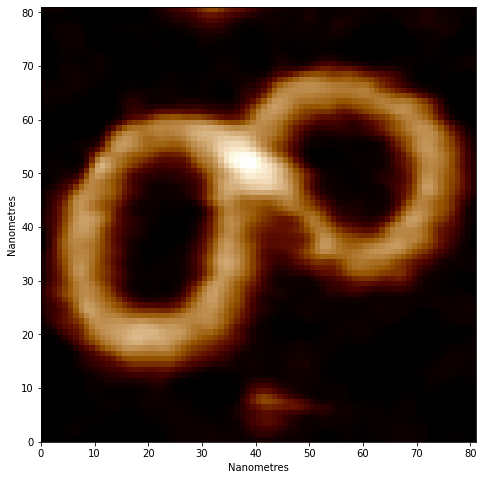

In [27]:
fig, ax = Images(
    data=grain_stats["plots"][0]["data"],
    filename=f"{filtered_image.filename}_grain0",
    output_dir="img/",
    save=True,
    colorbar=False,
    **plotting_config,
).plot_and_save()
fig

[Mon, 06 Mar 2023 07:45:54] [INFO    ] [topostats] [/home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle_grain0] : Image saved to : /home/neil/work/projects/topostats/TopoStats/tests/resources/minicircle_grain0


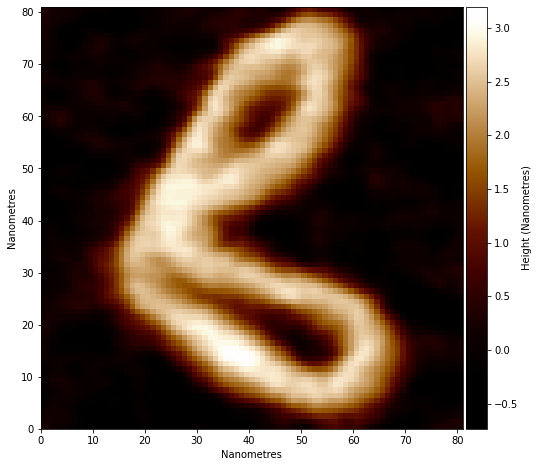

In [36]:
fig, ax = Images(
    data=grain_stats["plots"][3]["data"],
    filename=f"{filtered_image.filename}_grain0",
    output_dir="img/",
    save=True,
    colorbar=True,
    **plotting_config,
).plot_and_save()
fig

# grain_stats["plots"]

## DNA Tracing

When working with molecules it is possible to calculate DNA Tracing Statistics using the `dnaTrace` and `traceStats`
classes.

**NB** These classes are likely to undergo refactoring and change in the coming months, this Notebook will be updated
in light of changes. Currently there are very few options that map to the configuration. For that reason the options are
not currently detailed and described in this Notebook, although the [API
Documentation](https://afm-spm.github.io/TopoStats/topostats.tracing.html) details them.

Currently this is a two stage process

1. `dnaTrace` traces molecules to produce a "trace_object".
2. `traceStats` takes the "trace_object" and produces a Pandas DataFrame

In [ ]:
dna_traces = dnaTrace(
    full_image_data=filtered_image.images["gaussian_filtered"],
    grains=grains.directions["upper"]["labelled_regions_02"],
    filename=grains.filename.stem,
    pixel_size=grains.pixel_to_nm_scaling,
    **dnatracing_config,
)
dna_traces.trace_dna()
tracing_stats = traceStats(trace_object=dna_traces, image_path=all_scan_data.img_dict["minicircle"]["img_path"])

The resulting Pandas DataFrame is stored in the `df` attribute of the `traceStats` object, to view it we...

### Merge GrainStats and TracingStats

Its reasonable to want to have a single data set with which we work and so we now merge the GrainStats data frame with
the Tracing Statistics and then save them to CSV for subsequent use. The following saves them to the directory in which
the Notebook is running with the filename `minicircle_example.csv`

In [ ]:
all_stats_df = grain_stats["statistics"].merge(tracing_stats.df, on=["image", "molecule_number"])
all_stats_df.to_csv("minicircle_example.csv")

These statistics can now be plotted to show the distribution of the different metrics. Please see the Jupyter Notebook
`notebooks/02-Summary-statistics-and-plots.ipynb` for examples of how to plot these statistics.